In [2]:
import os
import xml.etree.ElementTree as et
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt

import time

_start_time = time.time()

def tic():
    global _start_time
    _start_time = time.time()

def tac():
    
    t_time = time.time() - _start_time
    print("Time passed: ", t_time, "seconds")
tic()    
dataSet = []
parentDir = ""
annotations = "archive/annotations"
dataLabels = ['with_mask','without_mask','mask_weared_incorrect']
print("Generating data in CSV format....")

#Used code based on the code example from the kaggle database
for file in os.listdir(parentDir + annotations):
    xml = et.parse(parentDir+annotations+"/"+file) 
    root = xml.getroot()
    img = root[1].text
    for i in range(4,len(root)):
        row = []
        row.append(img)
        row.append(root[i][0].text)
        for point in root[i][5]:
            row.append(point.text)
        dataSet.append(row)
totalCut = 0
totalUsed = 0
total = 0
smallImage = 0
mask_weared_incorrect = 0
LowestHeight = 30
LowestWidth = 30
rotationAngles = [315, 330, 0, 30, 45]
usedImage = []
usedLabel = []
testImages = []
testLabels = []
trainImages = []
trainLabels = []
cropImages = []
originalImages = []
index = 0
location = []
for i in range(len(dataSet)):
    width = int(dataSet[i][5])-int(dataSet[i][3])
    height = int(dataSet[i][4])-int(dataSet[i][2])
    if (LowestWidth <= width) and (LowestHeight <= height):
        img = cv2.imread("archive/images/"+dataSet[i][0])
        originalImages.append(img)
        crop_img = img[int(dataSet[i][3]):int(dataSet[i][5]), int(dataSet[i][2]):int(dataSet[i][4])]
        for j in range(len(rotationAngles)):
            scipyImage = ndimage.rotate(crop_img, rotationAngles[j])
            cropImages.append(scipyImage)
            location.append(index)
            index += 1
            resize_crop = cv2.resize(crop_img,(LowestWidth,LowestHeight))
            usedImage.append(resize_crop)
            for k in range(3):
                if(dataSet[i][1] == dataLabels[k]):
                    usedLabel.append(k)
                    if k == 2:
                        mask_weared_incorrect += 1;
                    break
            totalUsed += 1
            total +=1
    total += 1
totalCut = total - totalUsed
usedImageArray = np.array(usedImage) / 255
usedLabelArray = np.array(usedLabel)
locationArray = np.array(location)
trainImages, testImages, trainLabels, testLabels, trainLocation, testLocation = train_test_split(usedImageArray, 
                                                                                                 usedLabelArray, locationArray, 
                                                                                               test_size=0.1, random_state=69)
print("totalCut: ", totalCut, " total: ",total, " totalUsed: ", totalUsed)
print("Label: ", usedLabel[0])
tac()
cv2.imshow("photo", usedImage[0])
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

Generating data in CSV format....
totalCut:  4072  total:  10607  totalUsed:  6535
Label:  1
Time passed:  35.27625894546509 seconds


-1

In [3]:
search = 82
print("Label: ", dataLabels[testLabels[search]])
cv2.imshow("cropped", cropImages[testLocation[search]])
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

Label:  with_mask


-1

In [4]:
print("Total Data Set: ", len(usedLabelArray))
print("Total Test Set: ", len(testLabels))
print("Total Train Set: ", len(trainLabels))
print("Number of Masked worn Incorrect: ", mask_weared_incorrect)

Total Data Set:  6535
Total Test Set:  654
Total Train Set:  5881
Number of Masked worn Incorrect:  285


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        73792     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                589888    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 667,459
Trainable params: 667,459
Non-trainable params: 0
__________________________________________________

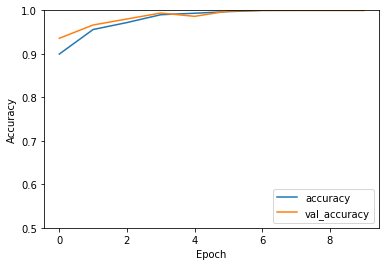

In [5]:
tic()
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(LowestHeight, LowestWidth, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))
model.summary()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

history = model.fit(trainImages, trainLabels, epochs=10, validation_data=(testImages, testLabels))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=2)
print("test accuracy: ", test_acc)
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
tac()

In [8]:
#Remember to Delete The Three Files
if (os.path.isfile("/Users/donnyhuang322/Desktop/Engineering/ECEN_and_CSCE/Senior Design/FullSystem/with_mask")):
    os.rmdir("/Users/donnyhuang322/Desktop/Engineering/ECEN_and_CSCE/Senior Design/FullSystem/with_mask")
if (os.path.isfile("/Users/donnyhuang322/Desktop/Engineering/ECEN_and_CSCE/Senior Design/FullSystem/without_mask")):
    os.rmdir("/Users/donnyhuang322/Desktop/Engineering/ECEN_and_CSCE/Senior Design/FullSystem/without_mask")
if (os.path.isfile("/Users/donnyhuang322/Desktop/Engineering/ECEN_and_CSCE/Senior Design/FullSystem/mask_weared_incorrect")):
    os.rmdir("/Users/donnyhuang322/Desktop/Engineering/ECEN_and_CSCE/Senior Design/FullSystem/mask_weared_incorrect")    
for i in range(3):
    path = os.path.join(parentDir, dataLabels[i])
    os.mkdir(path)

sample = len(testLabels)
predict = model.predict(testImages)
percentAccuracy = []
for i in range(sample):
    total = 0
    greatest = predict[i][0]
    least = predict[i][0]
    index = 0
    percentage = 0
    for j in range(3):
        if predict[i][j] > greatest:
            greatest = predict[i][j]
            index = j
        if predict[i][j] < least:
            least = predict[i][j]
    for j in range(3):
        total += predict[i][j] - least
    greatest = greatest - least
    percentage = greatest / total * 100
    #print("Percent Accuracy: ", percentage)
    #cv2.imshow("photo", cropImages[testLocation[i]])
    cv2.imwrite(parentDir+dataLabels[index]+"/image"+str(i)+".png", cropImages[testLocation[i]])

In [9]:
specialSet = [0,0,1,2,2,0,0,2,0,0]
specialImages = []
specialResizes = []
for i in range(len(specialSet)):
    img = cv2.imread("testSet/test"+str(i)+".png")
    specialImages.append(img)
    resize_crop = cv2.resize(img,(LowestWidth,LowestHeight))
    specialResizes.append(resize_crop)
specialArray = np.array(specialResizes) / 255
specialPredict = model.predict(specialArray)
for i in range(len(specialSet)):
    total = 0
    greatest = specialPredict[i][0]
    least = specialPredict[i][0]
    index = 0
    percentage = 0
    for j in range(3):
        if specialPredict[i][j] > greatest:
            greatest = specialPredict[i][j]
            index = j
        if specialPredict[i][j] < least:
            least = specialPredict[i][j]
    for j in range(3):
        total += specialPredict[i][j] - least
    greatest = greatest - least
    percentage = greatest / total * 100
    print("Prediction of test",i, ": ",dataLabels[index], "Confidence: ", percentage)
    print("Reality: ", dataLabels[specialSet[i]])
    print()
    cv2.imshow("photo", specialImages[i])
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.waitKey(1)

Prediction of test 0 :  with_mask Confidence:  68.8653679768337
Reality:  with_mask

Prediction of test 1 :  with_mask Confidence:  79.84271596992785
Reality:  with_mask

Prediction of test 2 :  without_mask Confidence:  93.75166701026481
Reality:  without_mask

Prediction of test 3 :  without_mask Confidence:  87.82165049617664
Reality:  mask_weared_incorrect

Prediction of test 4 :  mask_weared_incorrect Confidence:  64.06686894936341
Reality:  mask_weared_incorrect

Prediction of test 5 :  with_mask Confidence:  66.00118785522491
Reality:  with_mask

Prediction of test 6 :  with_mask Confidence:  83.53747187811273
Reality:  with_mask

Prediction of test 7 :  mask_weared_incorrect Confidence:  53.526969387032885
Reality:  mask_weared_incorrect

Prediction of test 8 :  with_mask Confidence:  64.28492977012232
Reality:  with_mask

Prediction of test 9 :  with_mask Confidence:  78.9467488347903
Reality:  with_mask



In [10]:
img = cv2.imread("testSet/test9.png")

blur = cv2.blur(img,(21,21))
blurMore = cv2.blur(img,(51,51))
cv2.imshow('my image',img)
cv2.imshow('blur',blur)
cv2.imshow('more blur',blurMore)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [25]:
import cv2
import numpy as np
import os
tic()
i = 1
masks = 0
maxObjectNumber = 0
VideoFrames = parentDir + "VideoFrames/"
DetectedFaces = parentDir + "DetectedFaces/"
FrameNumber ="Frame" + str(i)
ObjectNumberArray = []
while os.path.exists(DetectedFaces + FrameNumber + ".txt"):
    f = open(DetectedFaces + FrameNumber + ".txt", "r")
    for line in f:
        faceObject = []
        for word in line.split():
            faceObject.append(int(word))
        redundant_list = []
        img = cv2.imread("VideoFrames/" + FrameNumber + ".jpg")
        width = faceObject[3]
        height = faceObject[4]
        centerx = round(faceObject[1] + width/2)
        crop_img = img[round(faceObject[2]+height/10):round(faceObject[2]+height*2/3), round(centerx - width/4):round(centerx + width/4)]
        resize_crop = cv2.resize(crop_img,(LowestWidth,LowestHeight))
        #cv2.imshow("testImage", resize_crop)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
        #cv2.waitKey(1)
        redundant_list.append(resize_crop)
        img_array = np.array(redundant_list)/255
        array_predict = model.predict(img_array)
        #print("Prediction#" + str(i) +": "+ dataLabels[np.argmax(array_predict)])
        #print("with mask: " + str(array_predict[0][0])+
        #      "without mask: " +str(array_predict[0][1])+"mask_weared_incorrect: " +str(array_predict[0][2]))
        #cv2.imshow("testImage", crop_img)
        #cv2.waitKey(0)
        #cv2.destroyAllWindows()
        #cv2.waitKey(1)
        blur = cv2.blur(crop_img, (20,20))
        img[round(faceObject[2]+height/10):round(faceObject[2]+height*2/3), round(centerx - width/4):round(centerx + width/4)] = blur
        if np.argmax(array_predict):
            cv2.rectangle(img, (round(centerx - width/4),round(faceObject[2]+height/10)),(round(centerx + width/4),round(faceObject[2]+height*2/3)),(0,0,255),2)
        else:
            seen = 0
            for j in range(len(ObjectNumberArray)):
                if faceObject[0] == ObjectNumberArray[j]:
                    seen = 1
            if not seen:
                ObjectNumberArray.append(faceObject[0])
                masks += 1
        if faceObject[0] > maxObjectNumber:
            maxObjectNumber = faceObject[0]
        #print("Frame number: "+ FrameNumber)
        os.remove(VideoFrames + FrameNumber + ".jpg")
        cv2.imwrite(VideoFrames + FrameNumber +".jpg",img)
        
    i += 1
    FrameNumber = "Frame" + str(i)
tac()

Time passed:  5.769634962081909 seconds


In [26]:
import cv2
import numpy as np
import os.path
from os import path
tic()
i = 1
VideoFrames = parentDir + "VideoFrames/"
FramePath = VideoFrames + "Frame" + str(i) + ".jpg"
first = cv2.imread(FramePath)
frameSize = (first.shape[1], first.shape[0])
#out = cv2.VideoWriter('/Users/donnyhuang322/AndroidStudioProjects/MaskEnforcerPolicyApp/app/src/main/res/raw/output_video.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 16, frameSize)
out = cv2.VideoWriter('output_video.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 15, frameSize)

while path.exists(FramePath):
    video = cv2.imread(FramePath)
    #cv2.imshow('image', img)
    #cv2.waitKey(0)
    resizeImage = cv2.resize(video, frameSize)
    out.write(resizeImage)
    i += 1
    FramePath = VideoFrames + "Frame" + str(i) + ".jpg"

out.release()
tac()

Time passed:  2.4949419498443604 seconds


In [46]:
import mysql.connector
#https://dev.mysql.com/doc/connector-python/en/connector-python-example-cursor-transaction.html
try:
  cnx = mysql.connector.connect(user='root', password='atrocity',
                              host='100.64.13.34',
                              database='data')
except mysql.connector.Error as err:
  if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
    print("Something is wrong with your user name or password")
  elif err.errno == errorcode.ER_BAD_DB_ERROR:
    print("Database does not exist")
  else:
    print(err)
else:
    cursor = cnx.cursor()
    refresh_masks = "DELETE FROM Stats";
    cursor.execute(refresh_masks);
    add_masks = ("INSERT INTO Stats "
               "(Masks, Total) "
               "VALUES (%s, %s)")
    masks_data = (masks, maxObjectNumber)
    cursor.execute(add_masks, masks_data)
    cnx.commit()
    cnx.close()